# RNN의 문제점

## 기울기 소실과 폭발의 원인

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 2
H = 3
T = 20

In [3]:
dh = np.ones((N, H))
np.random.seed(3)
# Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H)*0.5

In [4]:
norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2))/N
    norm_list.append(norm)

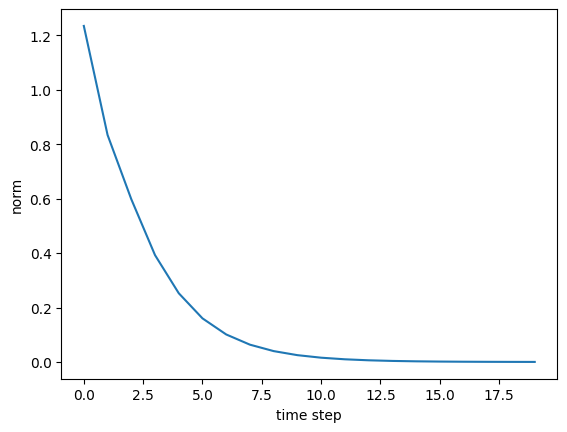

In [5]:
plt.plot(norm_list)
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

## 기울기 폭발 대책

In [6]:
import numpy as np

dW1 = np.random.rand(3, 3)*10
dW2 = np.random.rand(3, 3)*10
grads = [dW1, dW2]
max_norm = 5.0

In [7]:
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad*82)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate
            
    return grads

# LSTM 구현

In [30]:
from common.layers import *
from common.functions import sigmoid


class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f*c_prev + g*i
        h_next = o*np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        
        ds = dc_next + (dh_next * o)*(1-tanh_c_next**2)
        
        dc_prev = ds*f
        
        di = ds*g
        df = ds*c_prev
        do = dh_next*tanh_c_next
        dg = ds*i
        
        di *= i*(1-i)
        df *= f*(1-f)
        do *= o*(1-o)
        dg *= (1-g**2)
        
        dA = np.hstack((df, dg, di, do))
        
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        
        return dx, dh_prev, dc_prev

## Time LSTM 구현

In [31]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:            
            self.c = np.zeros((N, H), dtype='f')
        
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :]+dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs
    
    def set_state(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None

In [32]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W
        
    def forward(self, xs):
        N, T = xs.shape  # N(batch), T(timesteps)
        V, D = self.W.shape  # V(vocab_size), D(embedding_size)
        
        out = np.empty((N, T, D), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)
        
        return out
    
    def backward(self, dout):
        N, T, D = dout.shape
        
        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]
            
        self.grads[0][...] = grad
        return None

In [33]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params
        
        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)
    
    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params
        
        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)
        
        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dx

In [34]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1
        
    def forward(self, xs, ts):
        N, T, V = xs.shape
        
        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)
        
        mask = (ts != self.ignore_label)
        
        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)
        
        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()
        
        self.cache = (ts, ys, mask, (N, T, V))
        return loss
    
    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache
        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기 0으로 설정
        
        dx = dx.reshape((N, T, V))
        
        return dx

In [35]:
class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask

# LSTM을 사용한 언어 모델

In [36]:
from common.base_model import BaseModel

In [37]:
class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size = 100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D)/100).astype('f')
        lstm_Wx = (rn(D, 4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()

In [42]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

In [39]:
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

In [40]:
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.12
| 에폭 1 |  반복 21 / 1327 | 시간 4[s] | 퍼플렉서티 2785.71
| 에폭 1 |  반복 41 / 1327 | 시간 8[s] | 퍼플렉서티 1233.88
| 에폭 1 |  반복 61 / 1327 | 시간 12[s] | 퍼플렉서티 952.55
| 에폭 1 |  반복 81 / 1327 | 시간 16[s] | 퍼플렉서티 790.36
| 에폭 1 |  반복 101 / 1327 | 시간 20[s] | 퍼플렉서티 657.30
| 에폭 1 |  반복 121 / 1327 | 시간 23[s] | 퍼플렉서티 637.19
| 에폭 1 |  반복 141 / 1327 | 시간 27[s] | 퍼플렉서티 607.05
| 에폭 1 |  반복 161 / 1327 | 시간 31[s] | 퍼플렉서티 572.40
| 에폭 1 |  반복 181 / 1327 | 시간 35[s] | 퍼플렉서티 579.30
| 에폭 1 |  반복 201 / 1327 | 시간 39[s] | 퍼플렉서티 506.14
| 에폭 1 |  반복 221 / 1327 | 시간 44[s] | 퍼플렉서티 480.14
| 에폭 1 |  반복 241 / 1327 | 시간 48[s] | 퍼플렉서티 450.70
| 에폭 1 |  반복 261 / 1327 | 시간 52[s] | 퍼플렉서티 459.71
| 에폭 1 |  반복 281 / 1327 | 시간 56[s] | 퍼플렉서티 453.51
| 에폭 1 |  반복 301 / 1327 | 시간 60[s] | 퍼플렉서티 385.87
| 에폭 1 |  반복 321 / 1327 | 시간 64[s] | 퍼플렉서티 344.41
| 에폭 1 |  반복 341 / 1327 | 시간 68[s] | 퍼플렉서티 405.51
| 에폭 1 |  반복 361 / 1327 | 시간 72[s] | 퍼플렉서티 402.54
| 에폭 1 |  반복 381 / 1327 | 시간 76[s] | 퍼플렉서티 335.24
| 에폭 

| 에폭 3 |  반복 541 / 1327 | 시간 685[s] | 퍼플렉서티 135.90
| 에폭 3 |  반복 561 / 1327 | 시간 689[s] | 퍼플렉서티 118.22
| 에폭 3 |  반복 581 / 1327 | 시간 693[s] | 퍼플렉서티 106.03
| 에폭 3 |  반복 601 / 1327 | 시간 698[s] | 퍼플렉서티 148.04
| 에폭 3 |  반복 621 / 1327 | 시간 702[s] | 퍼플렉서티 142.93
| 에폭 3 |  반복 641 / 1327 | 시간 706[s] | 퍼플렉서티 127.90
| 에폭 3 |  반복 661 / 1327 | 시간 711[s] | 퍼플렉서티 119.73
| 에폭 3 |  반복 681 / 1327 | 시간 715[s] | 퍼플렉서티 99.77
| 에폭 3 |  반복 701 / 1327 | 시간 719[s] | 퍼플렉서티 117.82
| 에폭 3 |  반복 721 / 1327 | 시간 724[s] | 퍼플렉서티 125.80
| 에폭 3 |  반복 741 / 1327 | 시간 728[s] | 퍼플렉서티 108.16
| 에폭 3 |  반복 761 / 1327 | 시간 733[s] | 퍼플렉서티 104.31
| 에폭 3 |  반복 781 / 1327 | 시간 737[s] | 퍼플렉서티 104.36
| 에폭 3 |  반복 801 / 1327 | 시간 741[s] | 퍼플렉서티 115.59
| 에폭 3 |  반복 821 / 1327 | 시간 746[s] | 퍼플렉서티 117.12
| 에폭 3 |  반복 841 / 1327 | 시간 750[s] | 퍼플렉서티 115.39
| 에폭 3 |  반복 861 / 1327 | 시간 755[s] | 퍼플렉서티 119.42
| 에폭 3 |  반복 881 / 1327 | 시간 759[s] | 퍼플렉서티 106.21
| 에폭 3 |  반복 901 / 1327 | 시간 763[s] | 퍼플렉서티 132.03
| 에폭 3 |  반복 921 / 1327 | 시간 768

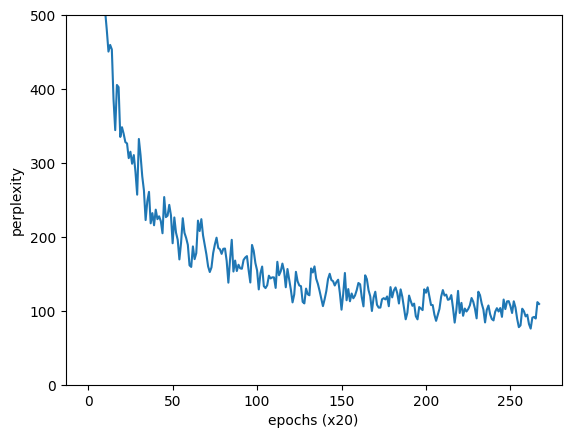

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  135.54361519340986


In [43]:
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

# RNNLM 추가 개선
- [버전 차이에 따른 error 대응](https://madrabbit7.tistory.com/56)

In [4]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.
     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [5]:
%matplotlib inline
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 3
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

| 에폭 1 |  반복 1 / 1327 | 시간 8[s] | 퍼플렉서티 9999.99
| 에폭 1 |  반복 21 / 1327 | 시간 9[s] | 퍼플렉서티 3480.73
| 에폭 1 |  반복 41 / 1327 | 시간 11[s] | 퍼플렉서티 1805.01
| 에폭 1 |  반복 61 / 1327 | 시간 12[s] | 퍼플렉서티 1404.96
| 에폭 1 |  반복 81 / 1327 | 시간 14[s] | 퍼플렉서티 1112.06
| 에폭 1 |  반복 101 / 1327 | 시간 15[s] | 퍼플렉서티 874.00
| 에폭 1 |  반복 121 / 1327 | 시간 16[s] | 퍼플렉서티 776.18
| 에폭 1 |  반복 141 / 1327 | 시간 18[s] | 퍼플렉서티 739.99
| 에폭 1 |  반복 161 / 1327 | 시간 19[s] | 퍼플렉서티 691.37
| 에폭 1 |  반복 181 / 1327 | 시간 20[s] | 퍼플렉서티 677.22
| 에폭 1 |  반복 201 / 1327 | 시간 22[s] | 퍼플렉서티 593.73
| 에폭 1 |  반복 221 / 1327 | 시간 23[s] | 퍼플렉서티 574.84
| 에폭 1 |  반복 241 / 1327 | 시간 24[s] | 퍼플렉서티 507.72
| 에폭 1 |  반복 261 / 1327 | 시간 26[s] | 퍼플렉서티 538.85
| 에폭 1 |  반복 281 / 1327 | 시간 27[s] | 퍼플렉서티 525.83
| 에폭 1 |  반복 301 / 1327 | 시간 29[s] | 퍼플렉서티 450.48
| 에폭 1 |  반복 321 / 1327 | 시간 30[s] | 퍼플렉서티 397.35
| 에폭 1 |  반복 341 / 1327 | 시간 31[s] | 퍼플렉서티 453.81
| 에폭 1 |  반복 361 / 1327 | 시간 33[s] | 퍼플렉서티 469.92
| 에폭 1 |  반복 381 / 1327 | 시간 34[s] | 퍼플렉서티 379.37
| 에